In [0]:
! pip uninstall tensorflow -y

Uninstalling tensorflow-1.15.0:
  Successfully uninstalled tensorflow-1.15.0


In [0]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 115kB/s 
     |████████████████████████████████| 3.8MB 53.7MB/s 
     |████████████████████████████████| 450kB 39.6MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
import sys
sys.modules['Image'] = Image 

print(Image.__file__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)
data_dir = './images'

/usr/local/lib/python3.6/dist-packages/PIL/Image.py
Num GPUs Available:  0
2.0.0


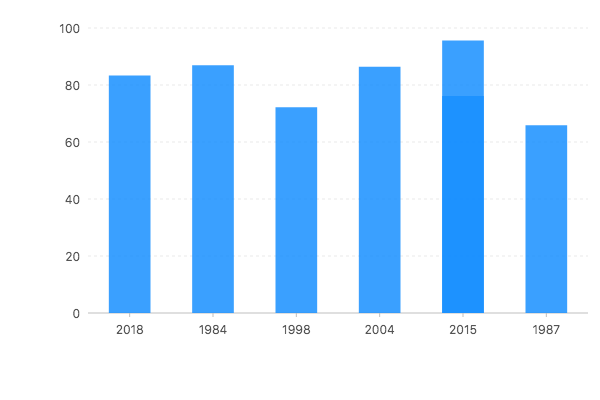

In [0]:
image = tf.keras.preprocessing.image.load_img('/content/images/009595d6-5d82-4c17-b6e3-28baf1994b78.png')
image

In [0]:
image_arr = tf.keras.preprocessing.image.img_to_array(image)
image_nparry = np.array(image_arr)
image_nparry.shape

(400, 600, 3)

In [0]:
from os import listdir
from os.path import isfile, join

import IPython.display as display

# list all raw images
sourcefiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and 'handy' not in f]
sourcefiles

for f in sourcefiles:
    raw_path = f'{data_dir}/{f}'
    handy_path = f'{data_dir}/handy_{f}'
    raw_image = tf.keras.preprocessing.image.load_img(raw_path)
    handy_image = tf.keras.preprocessing.image.load_img(handy_path)
    #display.display(display.Image(raw_path))
    #display.display(display.Image(handy_path))

In [0]:
def preprocess_image(image):
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

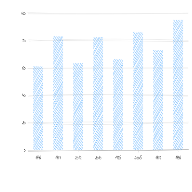

In [0]:
from io import BytesIO
image = load_and_preprocess_image('/content/images/handy_9f67a7bf-97d7-4109-9cd3-0833cfb05938.png')
raw = tf.image.encode_png(tf.dtypes.cast(image*255,dtype=tf.uint8))
im = Image.open(BytesIO(raw.numpy()))
im

In [0]:
raw_paths =  [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and 'handy' not in f]
handy_paths = [ f'handy_{f}' for f in raw_paths]
raw_paths = [ join(data_dir, f) for f in raw_paths]
handy_paths = [ join(data_dir, f) for f in handy_paths]

raw_files = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and 'handy' not in f]
ds = tf.data.Dataset.from_tensor_slices((raw_paths,handy_paths))
# 元组被解压缩到映射函数的位置参数中
def load_and_preprocess_from_path(raw_path, handy_path):
  return load_and_preprocess_image(raw_path), load_and_preprocess_image(handy_path)

image_ds = ds.map(load_and_preprocess_from_path)
image_ds

<MapDataset shapes: ((192, 192, 3), (192, 192, 3)), types: (tf.float32, tf.float32)>

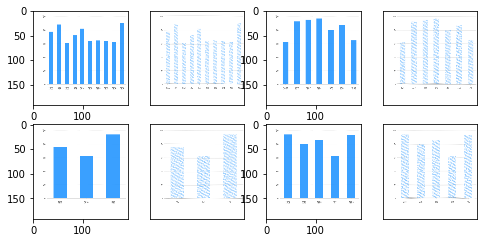

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, (image, himage) in enumerate(image_ds.take(4)):
  plt.subplot(4,4,n*2+1)
  plt.imshow(image)
  plt.subplot(4,4,n*2+2)
  plt.imshow(himage)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

IMG_HEIGHT=192
IMG_WIDTH=192


model = Sequential([
    Conv2D(96, 12, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    Conv2D(96, 12, padding='same', activation='relu'),
    Dense(3, activation='relu')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 96)      41568     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 96)      1327200   
_________________________________________________________________
dense (Dense)                (None, 192, 192, 3)       291       
Total params: 1,369,059
Trainable params: 1,369,059
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

In [0]:
train = image_ds.batch(2)
train_x = train.map(lambda x,y : x)
train_y = train.map(lambda x,y : y)

In [0]:
history = model.fit(train, epochs=2, )

Epoch 1/2
82/82 [==============================] - 986s 12s/step - loss: 0.3117 - accuracy: 0.2338
Epoch 2/2
82/82 [==============================] - 976s 12s/step - loss: 0.3109 - accuracy: 0.2327


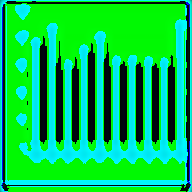

In [0]:
predictions = model.predict(train_x.take(3))
predict_tensor = tf.convert_to_tensor(predictions[0])
prediction_im = tf.image.encode_png(tf.dtypes.cast(predict_tensor*255,dtype=tf.uint8))
im = Image.open(BytesIO(prediction_im.numpy()))
im